In [1]:
#Librerías a usar
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pyflux as pf

### Importación de datos

In [2]:
#Leemos y visualizamos los datos:
df = pd.read_csv("ParisIndex-2016-2023.csv",index_col=0)
df

,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,...,2023-09-18,2023-09-19,2023-09-20,2023-09-21,2023-09-22,2023-09-25,2023-09-26,2023-09-27,2023-09-28,2023-09-29
Close,4522.450195,4537.629883,4480.470215,4403.580078,4333.759766,4312.740234,4378.75,4391.939941,4312.890137,4210.160156,...,7276.140137,7282.120117,7330.790039,7213.899902,7184.819824,7123.879883,7074.02002,7071.790039,7116.240234,7135.060059


In [3]:
#Primero transformamos el dataframe a un formato más cómodo en el que los índices de los valores son las fechas
df = df.T
#Posteriormente transformamos los índices a formato 'date-time' ya que originalmente son de tipo 'Object'
df.index = pd.to_datetime(df.index)
#vemos como quedó nuestro dataframe
df.head(5)

,Close
2016-01-04,4522.450195
2016-01-05,4537.629883
2016-01-06,4480.470215
2016-01-07,4403.580078
2016-01-08,4333.759766


### Retornos normales

$r_t  = \frac{y_t-y_{t-1}}{y_{t-1}}$

log returns $log(\frac{y_t}{y_{t-1}})$

In [34]:
def returns (df):
  returns  = df.diff()/df
  return returns.dropna()

def log_returns (df):
  returns  = df.shift(1)/df #con shift() se recorre el dataframe y en este caso es y_{t-1}
  return (np.log(returns)).dropna() 

### Visualización

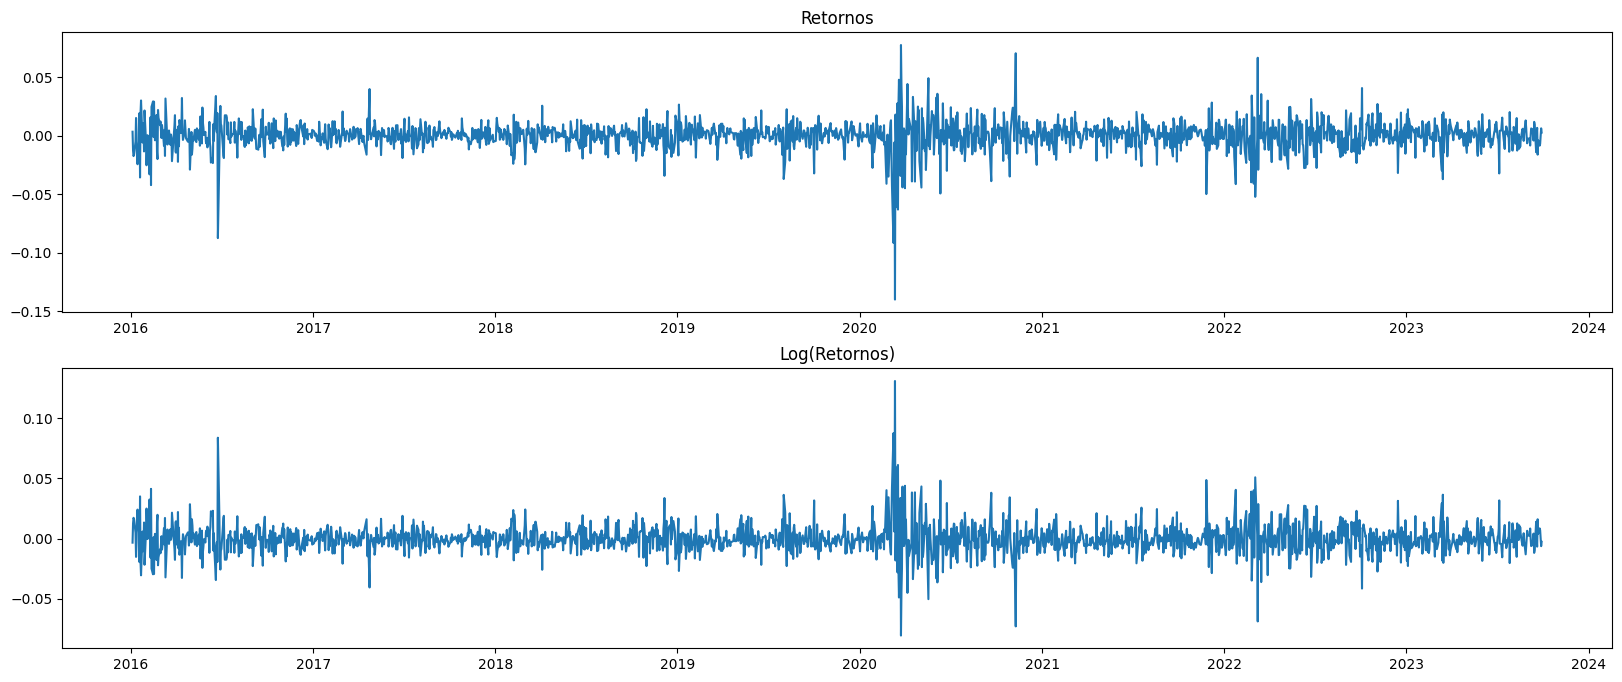

In [35]:
r = returns(df)
log_r = log_returns(df)

plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.plot(r)
plt.title("Retornos")

plt.subplot(2,1,2)
plt.plot(log_r)
plt.title("Log(Retornos)")
plt.show()

### Datos de entrenamiento y prueba

In [36]:
#Función para dividir el dataframe en datos de entrenamiento y prueba
def train_test(df,p=90): #p- pocentaje de datos de entrenamiento
    l=len(df)
    div=int(np.ceil(p*l/100))
    df_train = df.iloc[:div]
    df_test = df.iloc[div:]
    return df_train, df_test

train,test=train_test(r)
log_train, log_test = train_test(log_r)

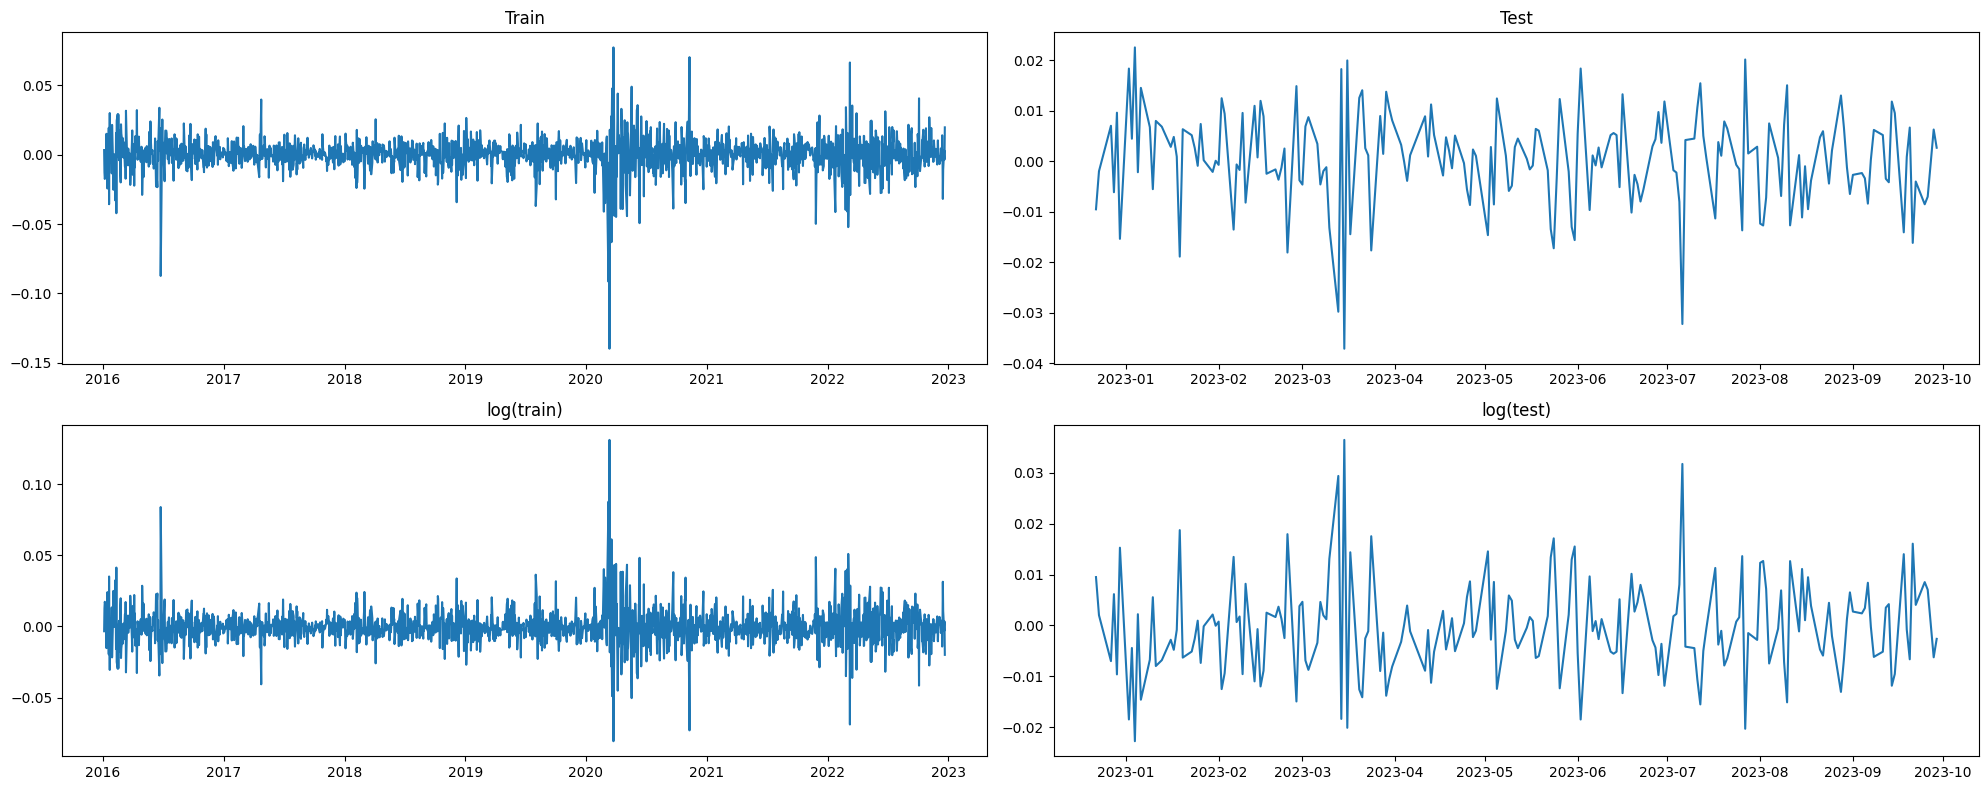

In [37]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(train)
plt.title("Train")

plt.subplot(2,2,2)
plt.plot(test)
plt.title("Test")

plt.subplot(2,2,3)
plt.plot(log_train)
plt.title("log(train)")

plt.subplot(2,2,4)
plt.plot(log_test)
plt.title("log(test)")
plt.tight_layout()
plt.show()

#### ACF y PACF

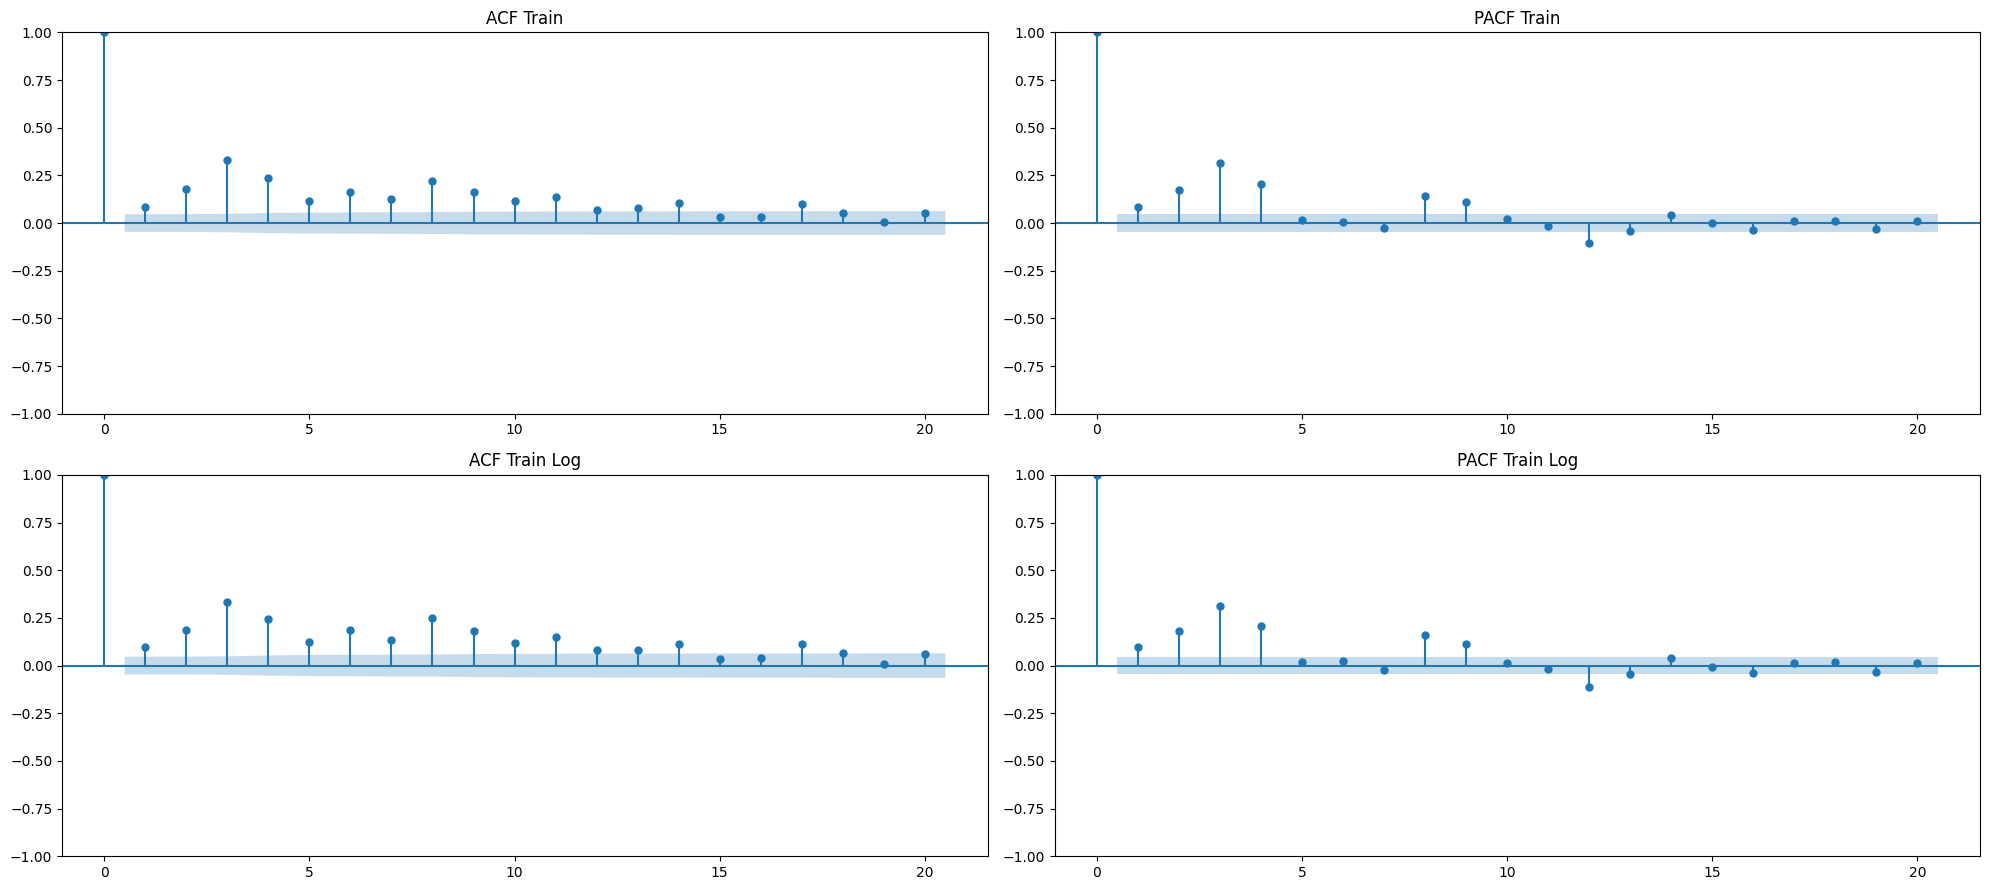

In [38]:
fig , ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2,figsize = (20,9))

train2 = (train**2).dropna()
log_train2 = (log_train**2).dropna()

plot_acf(train2,lags=20, ax=ax1)
plot_pacf(train2,lags=20, ax=ax2)
plot_acf(log_train2,lags=20, ax=ax3)
plot_pacf(log_train2,lags=20, ax=ax4)


ax1.set_title("ACF Train")
ax2.set_title("PACF Train")
ax3.set_title("ACF Train Log")
ax4.set_title("PACF Train Log")



plt.tight_layout()
plt.show()

vemos que para las dos series de entrenamiento de retornos el comportamiento de las ACF y PACF es muy similar, teniendo para la PACF un total de 2 picos positivos y por tanto sugiere que en principio $p=2$, por otro lado la ACF muestra entre 2 y 4 picos positivos, lo que sugiere que el parámetro q puede ser en principio $q=2,3$ o $4$


## GARCH

###### Nota: al trabajar con un dataframe desde un inicio y dado que las variables de datos de entrenamiento y logaritmo de entrenamiento son un dataframe, no es suficiente utilizar el atributo '.values' ya que devuelve un numpy array de dimensión (n,1) mientras que la función GARCH de la librería pyflux trabaja solamente con numpy array de dimensión (n,0) , es decir, un arreglo plano de números. Es por esto que se hace el siguiente renombramiento en las variables de entrenamiento y logaritmo de entrenamiento.

In [66]:
train = train.values.flatten()
log_train = log_train.values.flatten()

In [68]:
model = pf.GARCH(train,p=2,q=2)
model.fit().summary()

GARCH(2,2)                                                                                                
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 2                                           Log Likelihood: 5637.2293                         
End Date: 1786                                          AIC: -11262.4587                                  
Number of observations: 1785                            BIC: -11229.5356                                  
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0                                                              
q(1)                                 

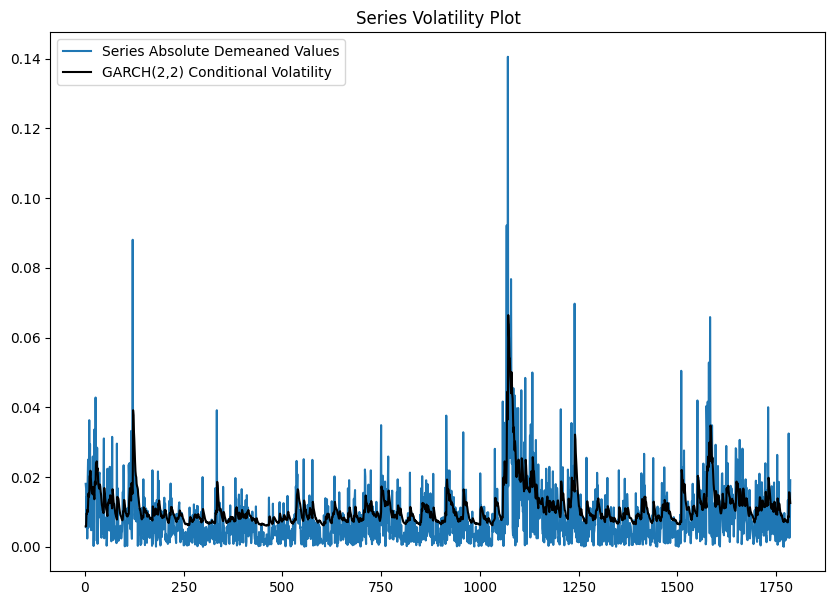

In [69]:
model.plot_fit()

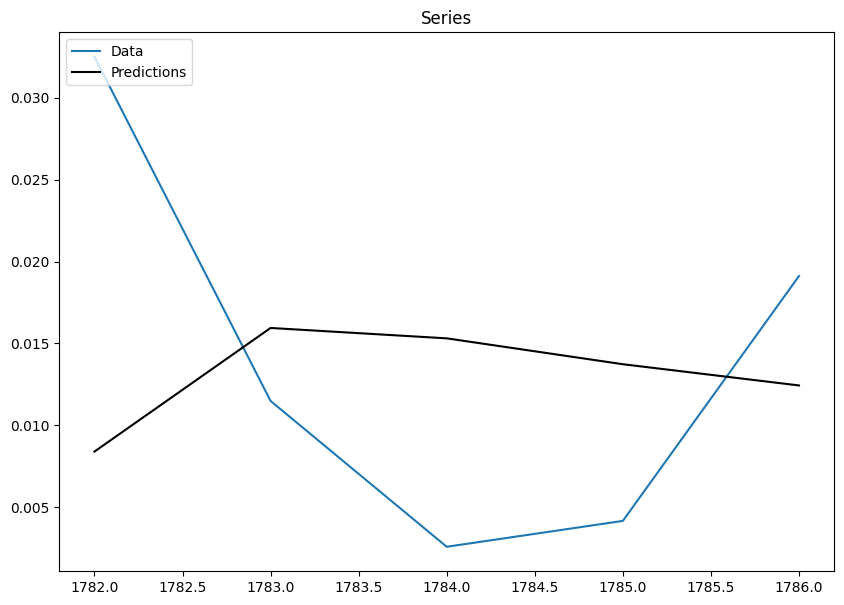

In [70]:
model.plot_predict_is()